## EDA

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import ast
from transformers import AutoTokenizer
import hashlib

In [2]:
#此段程式碼只在當工作目錄錯位時使用
os.chdir('nbme_data')
#先確認工作目錄是否為以下路徑
#'/home/user/ur_folder/nbme_data' (Linux)
print(os.getcwd())

/home/hjc/venv/NLP_Final/nbme_data


In [3]:
#讀取資料集
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
patient_notes = pd.read_csv("patient_notes.csv")

#將 train, features, patient_notes 合併成一個 DataFrame
df = train.merge(features, on="feature_num", how="left")
df = df.merge(patient_notes, on="pn_num", how="left")

In [15]:
#建立欄位 has_annotation，判斷這筆資料是否有標註診斷詞
def safe_to_list(x):
    """
    將字串化的 list 轉回 Python list。
    非字串／轉換失敗 → 回傳空 list。
    """
    if not isinstance(x, str):
        return []
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []
# 新增解析後的欄位
df['annotation_list'] = df['annotation'].apply(safe_to_list)
#以 list 是否為空決定 has_annotation
df['has_annotation'] = df['annotation_list'].apply(lambda lst: len(lst) > 0)


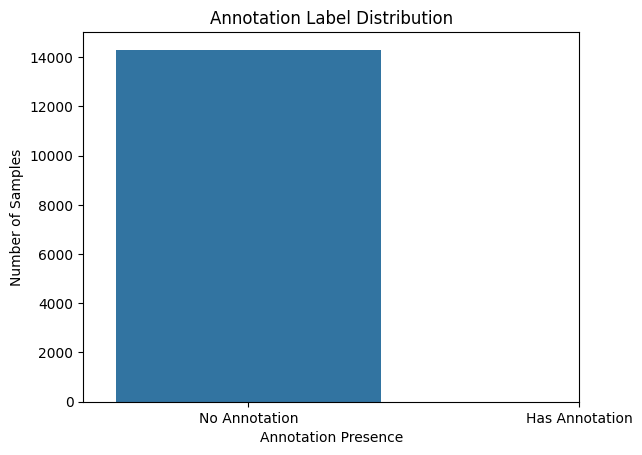

In [ ]:
#觀察資料集中有被標註與沒被標註的比例
sns.countplot(x='has_annotation', data=df)
plt.xticks([0, 1], ['No Annotation', 'Has Annotation'])
plt.title('Annotation Label Distribution')
plt.xlabel('Annotation Presence')
plt.ylabel('Number of Samples')
plt.show()

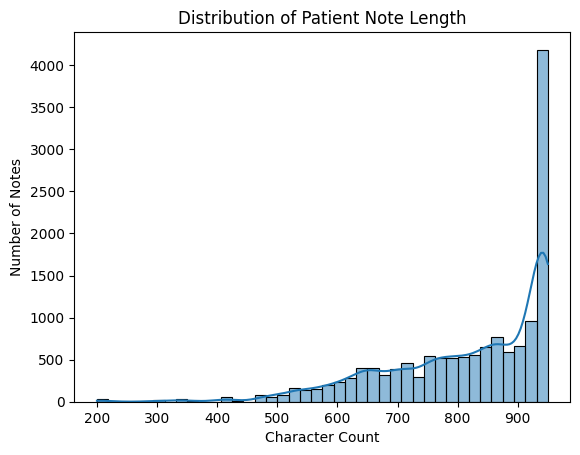

count    14300.000000
mean       816.794615
std        135.132370
min        200.000000
25%        733.000000
50%        857.000000
75%        937.000000
max        950.000000
Name: pn_length, dtype: float64


<Axes: xlabel='tok_len', ylabel='Count'>

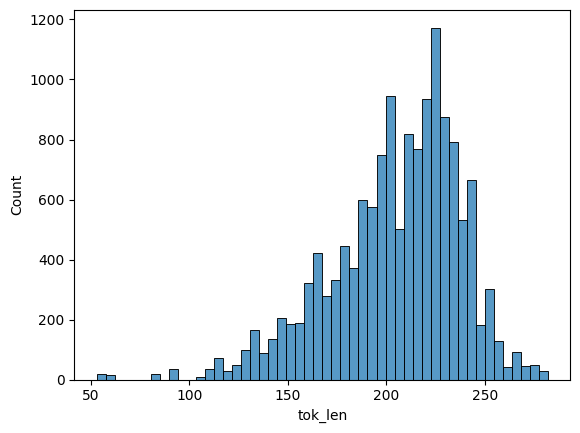

In [14]:
#了解病歷的平均字數，為 BERT tokenizer 做準備
df['pn_length'] = df['pn_history'].str.len()

sns.histplot(df['pn_length'], bins=40, kde=True)
plt.title('Distribution of Patient Note Length')
plt.xlabel('Character Count')
plt.ylabel('Number of Notes')
plt.show()

print(df['pn_length'].describe())

#但實際上我們應該要改成使用Token數而非字數！所以我多加了以下：
#Token 長度分布, 決定 max_length 與是否需要滑動窗口 / 長序列模型
tok = AutoTokenizer.from_pretrained('bert-base-uncased')
df['tok_len'] = df['pn_history'].apply(lambda x: len(tok(x).input_ids))
sns.histplot(df['tok_len'], bins=50)

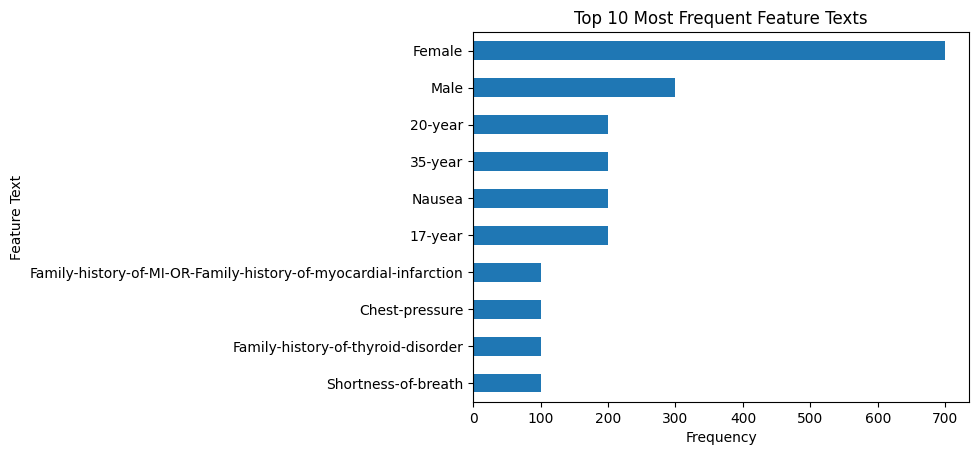

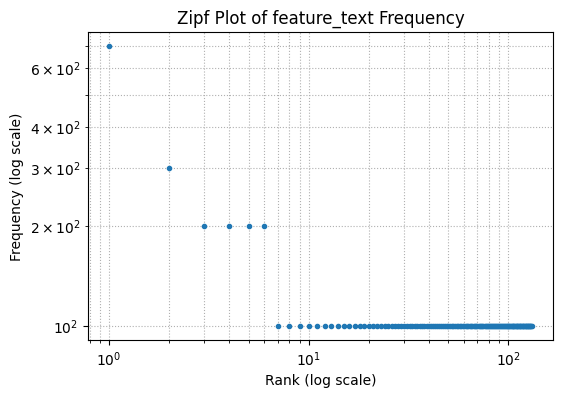

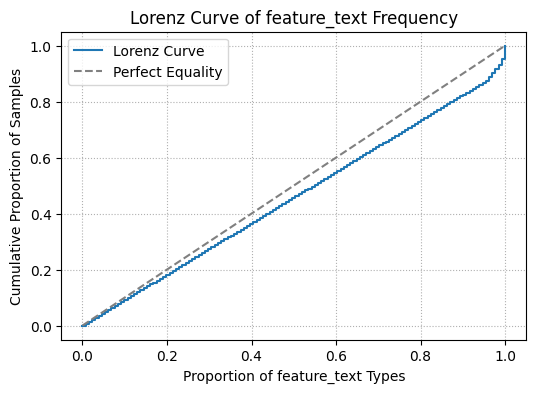

Gini 係數 (feature_text freq): 0.082


/tmp/ipykernel_15667/2837670141.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(cum_counts, prop_feats)


In [19]:
#哪些診斷詞（feature_text）最常出現
top_features = df['feature_text'].value_counts().head(10)

top_features.plot(kind='barh')
plt.title('Top 10 Most Frequent Feature Texts')
plt.xlabel('Frequency')
plt.ylabel('Feature Text')
plt.gca().invert_yaxis()  # To show the highest on top
plt.show()


# 計算每個 feature_text 的樣本數
feat_counts = df['feature_text'].value_counts().reset_index()
feat_counts.columns = ['feature_text', 'count']

# Zipf Plot: 斜率越陡，表示長尾越嚴重, 若前幾個點跟主體差距大 → 需要 loss 加權／下采樣
feat_counts['rank'] = np.arange(1, len(feat_counts) + 1)

plt.figure(figsize=(6, 4))
plt.loglog(feat_counts['rank'], feat_counts['count'], marker='.', linestyle='none')
plt.xlabel('Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Zipf Plot of feature_text Frequency')
plt.grid(True, which="both", ls=":")
plt.show()

# (B) Lorenz Curve: 曲線偏離對角線越遠 → 分布越不均, Gini ≈ 0 ⇒ 均勻；Gini → 1 ⇒ 極度不均
counts_sorted = np.sort(feat_counts['count'].values)          # 升冪
cum_counts   = np.cumsum(counts_sorted)
cum_counts   = np.insert(cum_counts, 0, 0) / cum_counts[-1]   # 歸一化並在開頭加 0
prop_feats   = np.linspace(0, 1, len(cum_counts))

plt.figure(figsize=(6, 4))
plt.plot(prop_feats, cum_counts, drawstyle='steps-post', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Equality')
plt.xlabel('Proportion of feature_text Types')
plt.ylabel('Cumulative Proportion of Samples')
plt.title('Lorenz Curve of feature_text Frequency')
plt.legend()
plt.grid(ls=':')
plt.show()

# 這邊補一個Gini係數
gini = 1 - 2 * np.trapz(cum_counts, prop_feats)
print(f"Gini 係數 (feature_text freq): {gini:.3f}")

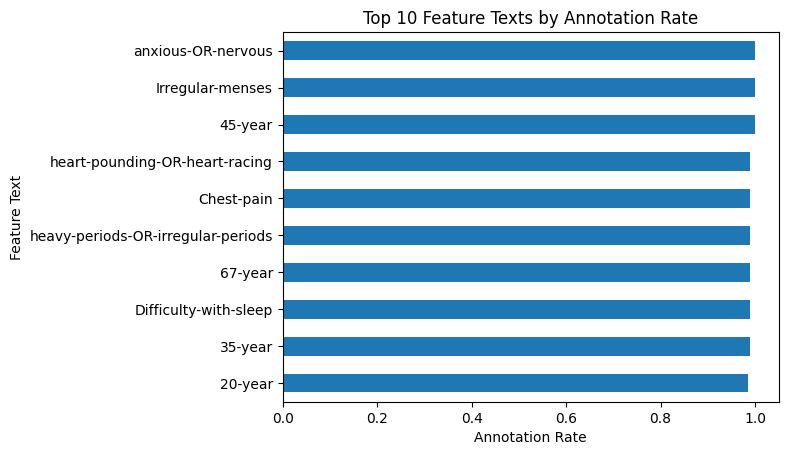

In [20]:
#不同診斷詞的標註比例是多少？(是否經常被認為有出現)
annotation_rate = df[df['has_annotation']].groupby('feature_text').size() / df.groupby('feature_text').size()
annotation_rate = annotation_rate.sort_values(ascending=False).head(10)

annotation_rate.plot(kind='barh')
plt.title('Top 10 Feature Texts by Annotation Rate')
plt.xlabel('Annotation Rate')
plt.ylabel('Feature Text')
plt.gca().invert_yaxis()
plt.show()

In [9]:
print(df.isnull().sum())

id                0
case_num_x        0
pn_num            0
feature_num       0
annotation        0
location          0
case_num_y        0
feature_text      0
case_num          0
pn_history        0
has_annotation    0
pn_length         0
dtype: int64


In [ ]:
#解析 annotation / location, 找出標註數與位置數不一致的異常列
def parse_list(x):
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

df['annotation_list'] = df['annotation'].apply(parse_list)
df['location_list']   = df['location']  .apply(parse_list)
df['ann_loc_mismatch'] = df.apply(lambda r: len(r.annotation_list)!=len(r.location_list), axis=1)
print('Mismatch rows:', df['ann_loc_mismatch'].sum())

Mismatch rows: 0


In [21]:
#class imbalance 檢視, 為後續 loss 加權或 undersampling 提供依據
feat_stats = (
    df.assign(label=df['annotation_list'].apply(lambda lst: int(len(lst)>0)))
      .groupby('feature_text')['label'].agg(['count','sum'])
      .assign(pos_rate=lambda d: d['sum']/d['count'])
      .sort_values('pos_rate',ascending=False)
)
feat_stats

,count,sum,pos_rate
feature_text,,,
anxious-OR-nervous,100,100,1.00
Irregular-menses,100,100,1.00
45-year,100,100,1.00
heart-pounding-OR-heart-racing,100,99,0.99
Chest-pain,100,99,0.99
...,...,...,...
No-rash,100,11,0.11
Unsuccessful-napping,100,7,0.07
Meningococcal-vaccine-status-unknown,100,2,0.02


In [22]:
#文本重複偵測, 同一病歷重複標註多 feature_text 時，只取一次或設置分層抽樣
df['pn_hash'] = df['pn_history'].str.replace(r'\s+', '', regex=True).apply(
    lambda x: hashlib.md5(x.encode()).hexdigest())
dup_notes = (
    df['pn_hash']
      .value_counts()                  # 先得到 Series
      .reset_index(name='cnt')         # index → pn_hash，計數欄直接命名為 'cnt'
      .rename(columns={'index': 'pn_hash'})
      .query('cnt > 1')                # 現在 query 找得到 'cnt'
)
dup_notes

,pn_hash,cnt
0,6b9e74bcabf420cf77212efd73fbf5de,18
1,fe149e9031e928cc9ab6d0979670ace6,18
2,e517fbaa447d303be22e787d3af2e9ee,18
3,768552c4e4aaf6f356bb5d22475d26b2,18
4,4c91c082f2c1322bcfd08e10ee2e9859,18
...,...,...
995,056e3a2b9924fdab7fc9e02844fb8fe2,9
996,01c7a6c4fdec0a61fe3175d9ee9675bf,9
997,9b7ef3d8b18ec708611273a74a8093a5,9
998,47f2bd1144c7bdf6a2757ff8edca2f6f,9
